In [ ]:

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
from sklearn.manifold import TSNE
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
import gower
from scipy.spatial.distance import cdist
import plotly.express as px
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt


# Select the right path, if colab use google library to import the file from the drive
# path = 'C:/Users/giaco/Documents/GitHub/Fintech_group13/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'
# path = 'C:\\Matteo\\0001_LM_SECONDOSEMESTRE\\FINANCIAL ENGINEERING\\ASSIGNMENTS FE\\LAB EPFL\\BC_1\\Dataset1_BankClients.xlsx'
path = 'C:/Users/nicol/GitHub_Nick/Fintech_group13/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'
# path  = 'C:/Users/andre/git_repos/Fintech_group13/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'
# path = 'C:/Users/leona/githubFolder/Fintech_group13/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/Colab Notebooks/FINTECH/BUSINESS_CASES_FINTECH/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'

# Load data in a DataFrame
data = pd.read_excel(path)

# Let's inspect the first 5 record
print(data.head())
# Drop the column by its actual name (e.g., 'ID' or the actual name of the column)
data = data.drop(columns=['ID'])  # Replace 'ID' with the actual column name to drop

# Example snippet (adjust as needed):
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']
numerical_features = data.drop(columns=categorical_columns)
categorical_features = data[categorical_columns].astype('category')

# Normalize numerical data
scaler = MinMaxScaler()
X_num = scaler.fit_transform(numerical_features)

# One-hot encode categorical data
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_cat = encoder.fit_transform(categorical_features).toarray()

# Final feature matrix
X = np.hstack((X_num, X_cat))
print("X shape:", X.shape)


   ID  Age  Gender  Job  Area  CitySize  FamilySize    Income    Wealth  \
0   1   24       1    1     2         2           4  0.668046  0.702786   
1   2   47       1    2     2         3           1  0.858453  0.915043   
2   3   38       0    2     1         2           2  0.926818  0.898316   
3   4   67       0    2     1         2           3  0.538797  0.423180   
4   5   33       0    2     1         3           1  0.806659  0.731404   

       Debt    FinEdu       ESG   Digital  BankFriend  LifeStyle    Luxury  \
0  0.262070  0.741853  0.483684  0.698625    0.618259   0.607877  0.897369   
1  0.730430  0.859423  0.537167  0.959025    0.785936   0.862271  0.913729   
2  0.441272  0.485953  0.649434  0.750265    0.699725   0.755404  0.765199   
3  0.600401  0.493144  0.533829  0.590165    0.675353   0.334432  0.517209   
4  0.831449  0.856286  0.784940  0.710026    0.758793   0.908878  0.611610   

     Saving  Investments  
0  0.283222            1  
1  0.821590            3  

In [1]:
# ---------------------------------------------------------------------------
gower_distances = gower.gower_matrix(X)
print("Gower distance matrix shape:", gower_distances.shape)
# gower_distances should be (n_samples, n_samples)

# Convert distance to similarity if you plan to use affinity='precomputed'
# similarity_matrix = 1 - gower_distances
similarity_matrix_gower = 1 / (1 + gower_distances)

# ---------------------------------------------------------------------------

tsne = TSNE(
    n_components=3,
    metric='precomputed',   # We have a precomputed distance matrix
    perplexity=30,          # Example value; tweak as needed
    random_state=42,
    init='random'
)
Y_3d_gower = tsne.fit_transform(gower_distances)
print("Y_3d_gower shape:", Y_3d_gower.shape)  

NameError: name 'gower' is not defined

In [ ]:
cluster_results_gower = {}
Y_3d_dict_gower = {}

for k in [2, 3, 4, 5]:
    # Perform spectral clustering on the similarity matrix
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='precomputed',
        random_state=42
    )
    labels = spectral.fit_predict(similarity_matrix_gower)
    
    # Store the labels (for each k) in a dictionary
    cluster_results_gower[k] = labels
    # Store the same t-SNE embedding in a dictionary (using the same key)
    Y_3d_dict_gower[k] = Y_3d_gower

In [ ]:
def plot_spectral_clusters(Y_3d_dict, cluster_results):
    """
    Plots the 3D t-SNE embedding for each k in cluster_results in a 2x2 grid,
    coloring points by cluster labels.
    """
    num_plots = min(4, len(cluster_results))  # Max 4 subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': '3d'})
    axs = axs.flatten()  # Flatten for easier indexing

    # Iterate over the first 4 k-values
    for idx, (k, labels) in enumerate(sorted(cluster_results.items())[:4]):
        Y_3d = Y_3d_dict[k]
        ax = axs[idx]

        # Generate k distinct colors
        colors = plt.cm.rainbow(np.linspace(0, 1, k))

        for cluster_id in range(k):
            mask = (labels == cluster_id)
            ax.scatter(
                Y_3d[mask, 0], Y_3d[mask, 1], Y_3d[mask, 2],
                facecolor=colors[cluster_id],
                edgecolor='k', alpha=0.8, label=f'Cluster {cluster_id+1}'
            )

        ax.set_title(f'k = {k}')
        ax.legend()

    # Hide empty subplots if we have fewer than 4 clusters
    for idx in range(len(cluster_results), 4):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.show()


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_spectral_clusters_plotly(Y_3d_dict, cluster_results):
    """
    Create interactive 3D scatter plots using Plotly in a single subplot layout.
    """
    num_plots = len(cluster_results)
    cols = 2
    rows = (num_plots + 1) // cols

    subplot_titles = [f'3D Scatter Plot of {k} Clusters' for k in sorted(cluster_results.keys())]

    fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles,
                        specs=[[{'type': 'scatter3d'} for _ in range(cols)] for _ in range(rows)])

    for idx, k in enumerate(sorted(cluster_results.keys()), start=1):
        labels = cluster_results[k]
        Y_3d = Y_3d_dict[k]

        scatter = px.scatter_3d(x=Y_3d[:, 0], y=Y_3d[:, 1], z=Y_3d[:, 2], color=labels)

        for trace in scatter['data']:
            fig.add_trace(trace, row=(idx - 1) // cols + 1, col=(idx - 1) % cols + 1)

    fig.update_traces(marker=dict(size=2.5))
    fig.update_layout(height=rows * 600, width=cols * 700, showlegend=False)
    fig.show()

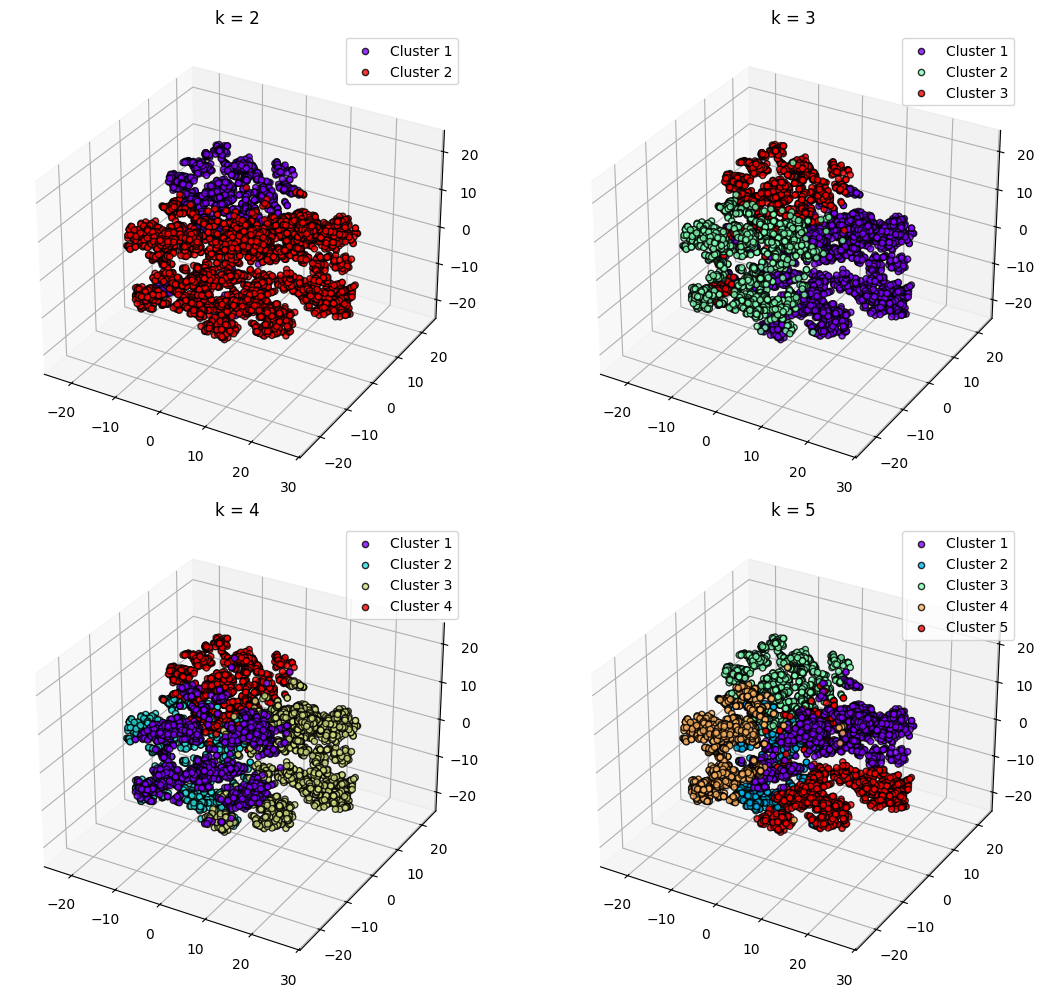

In [ ]:
plot_spectral_clusters(Y_3d_dict_gower, cluster_results_gower)
plot_spectral_clusters_plotly(Y_3d_dict_gower, cluster_results_gower)

In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

# Clustering evaluation
def evaluate_clustering(X, cluster_results, distances_matrix):
    k_values = list(cluster_results.keys())

    # Initialize metrics
    ch_scores = []
    db_scores = []
    sil_scores = []

    # Calculate metrics for each k
    for k in k_values:
        labels = cluster_results[k]
        ch_scores.append(calinski_harabasz_score(X, labels))
        db_scores.append(davies_bouldin_score(X, labels))
        sil_scores.append(silhouette_score(distances_matrix, labels, metric='precomputed'))

    # Plot evaluation metrics
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Calinski-Harabasz
    ax1.plot(k_values, ch_scores, 'bo-')
    ax1.set_title('Calinski-Harabasz score')
    ax1.set_xlabel('Number of clusters')
    ax1.grid(True)

    # Davies-Bouldin
    ax2.plot(k_values, db_scores, 'ro-')
    ax2.set_title('Davies-Bouldin score')
    ax2.set_xlabel('Number of clusters')
    ax2.grid(True)

    # Silhouette
    ax3.plot(k_values, sil_scores, 'go-')
    ax3.set_title('Silhouette score')
    ax3.set_xlabel('Number of clusters')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

    # Print optimal values
    print(f"Optimal k according to Calinski-Harabasz: {k_values[np.argmax(ch_scores)]}")
    print(f"Optimal k according to Davies-Bouldin: {k_values[np.argmin(db_scores)]}")
    print(f"Optimal k according to Silhouette: {k_values[np.argmax(sil_scores)]}")

    return ch_scores, db_scores, sil_scores



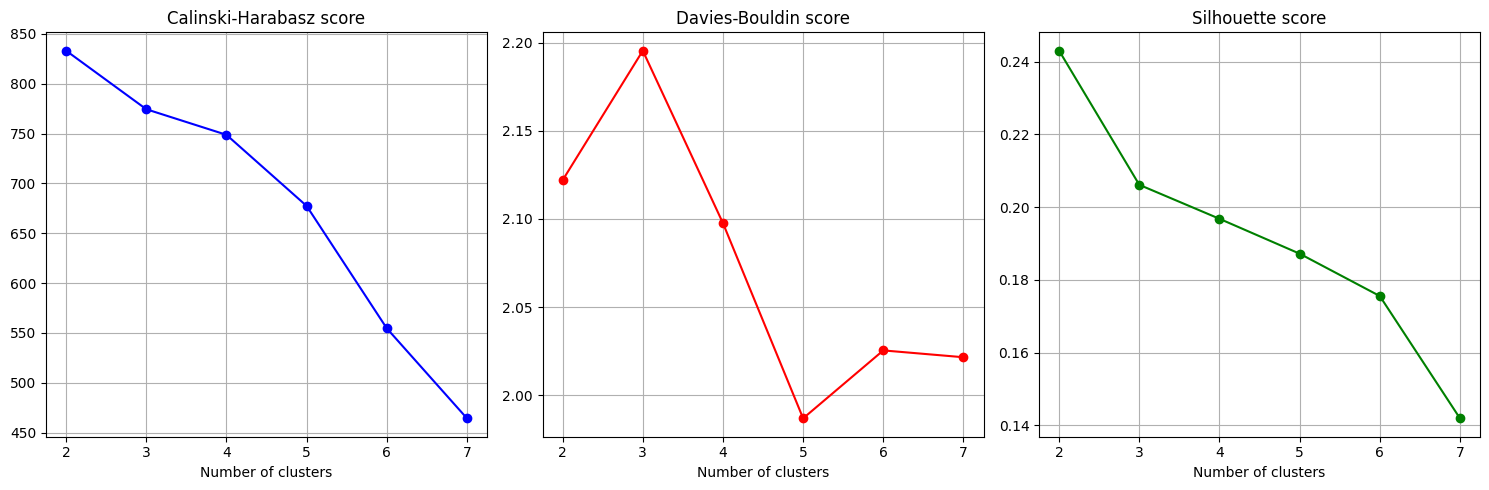

Optimal k according to Calinski-Harabasz: 2
Optimal k according to Davies-Bouldin: 5
Optimal k according to Silhouette: 2
Calinski-Harabasz scores: [833.1904694880441, 774.4676879038828, 748.7929862527166, 677.429982839933, 554.6044335970702, 464.3139150893102]
Davies-Bouldin scores: [2.122039252388658, 2.1955483958190816, 2.0976297752032647, 1.9867992525101523, 2.025369757683496, 2.0214946913446865]
Silhouette scores: [0.2430262, 0.20613316, 0.19678959, 0.18719116, 0.17553823, 0.1418927]


In [ ]:
# 2. Perform clustering for different k values
from sklearn.cluster import SpectralClustering

cluster_results_gower_eval = {}
for k in [2, 3, 4, 5, 6, 7]:
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='precomputed',
        random_state=42
    )
    labels = spectral.fit_predict(similarity_matrix_gower)
    cluster_results_gower_eval[k] = labels

# 3. Evaluate clustering
ch_scores, db_scores, sil_scores = evaluate_clustering(X, cluster_results_gower_eval, gower_distances)

print("Calinski-Harabasz scores:", ch_scores)
print("Davies-Bouldin scores:", db_scores)
print("Silhouette scores:", sil_scores)

In [ ]:
import numpy as np

k_selected = 3  # Choose the appropriate k value

# Gower distance
# Ensure we get the correct cluster labels
cluster_labels_gower = np.array(cluster_results_gower[k_selected])

# Add to Pandas DataFrame (data)
data['Cluster'] = pd.Series(cluster_labels_gower, index=data.index)

# Add to NumPy array (X)
cluster_labels_gower = cluster_labels_gower.reshape(-1, 1)  # Ensure it's the right shape
X_with_clusters_gower = np.hstack((X, cluster_labels_gower))

# Save results
data.to_excel('data_with_clusters_gower.xlsx', index=False)
np.save('X_with_clusters_gower.npy', X_with_clusters_gower)  # Save NumPy array

In [ ]:
def plot_cluster_radar(data):
    # Create a copy of the data for normalization
    plot_data = data.copy()

    # Normalize all numerical variables using MinMaxScaler
    scaler = MinMaxScaler()
    plot_data[numerical_features.columns] = scaler.fit_transform(plot_data[numerical_features.columns])

    # Calculate mean values for each numerical variable by cluster
    cluster_means = plot_data.groupby('Cluster')[numerical_features.columns].mean()

    # Set up the radar chart
    categories = numerical_features.columns
    num_vars = len(categories)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Plot for each cluster that exists
    for cluster in cluster_means.index:
        values = cluster_means.loc[cluster].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.1)

    # Set chart properties
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], categories)
    ax.set_title("Cluster profiles (all variables are normalized)", y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.show()


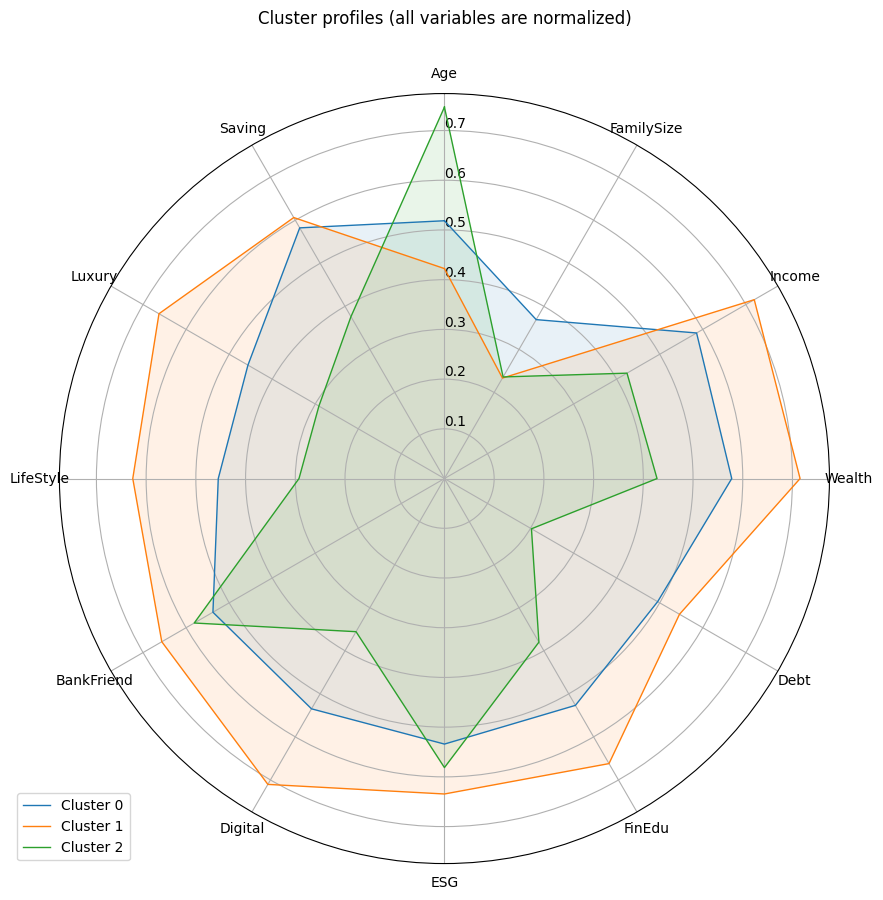

In [ ]:
data_clustered_gower = pd.read_excel('data_with_clusters_gower.xlsx')

plot_cluster_radar(data_clustered_gower)

In [ ]:
# Function to compute a customized distance: L1+rogerstanimoto
def compute_custom_distance(
    X_num: np.ndarray,
    X_cat: np.ndarray,
    w_num: float = 0.5,
    distance_num: str = 'cityblock',
    distance_cat: str = 'hamming'
) -> np.ndarray:
    
    # Numerical distance NxN
    dist_num = cdist(X_num, X_num, metric=distance_num)

    # Categorical distance NxN
    dist_cat = cdist(X_cat, X_cat, metric=distance_cat)

    # Weighted linear combination
    dist_matrix = w_num * dist_num + (1.0 - w_num) * dist_cat
    return dist_matrix

In [ ]:
# compute the custom distance matrix with custom weights
L1rog_distances = compute_custom_distance(
    X_num,
    X_cat,
    w_num = 0.6,   # Define the weights for the numerical and categorical features
    distance_num = 'cityblock',
    distance_cat = 'rogerstanimoto'
)


In [ ]:

# ---------------------------------------------------------------------------

tsne = TSNE(
    n_components=3,
    metric='precomputed',   # We have a precomputed distance matrix
    perplexity=52,          # Example value; tweak as needed
    random_state=42,
    init='random'
)
Y_3d_custom = tsne.fit_transform(L1rog_distances)


In [ ]:
similarity_matrix_custom = 1 / (1 + L1rog_distances)

cluster_results_custom = {}
Y_3d_dict_custom = {}

for k in [2, 3, 4, 5]:
    # Perform spectral clustering on the similarity matrix
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='precomputed',
        random_state=42
    )
    # print(np.isnan(spectral.fit_predict(similarity_matrix)).sum()) # Check for NaN values

    labels = spectral.fit_predict(similarity_matrix_custom)
    # print(np.isnan(labels).sum()) # Check for NaN values

    # Store the labels (for each k) in a dictionary
    cluster_results_custom[k] = labels
    # Store the same t-SNE embedding in a dictionary (using the same key)
    Y_3d_dict_custom[k] = Y_3d_custom

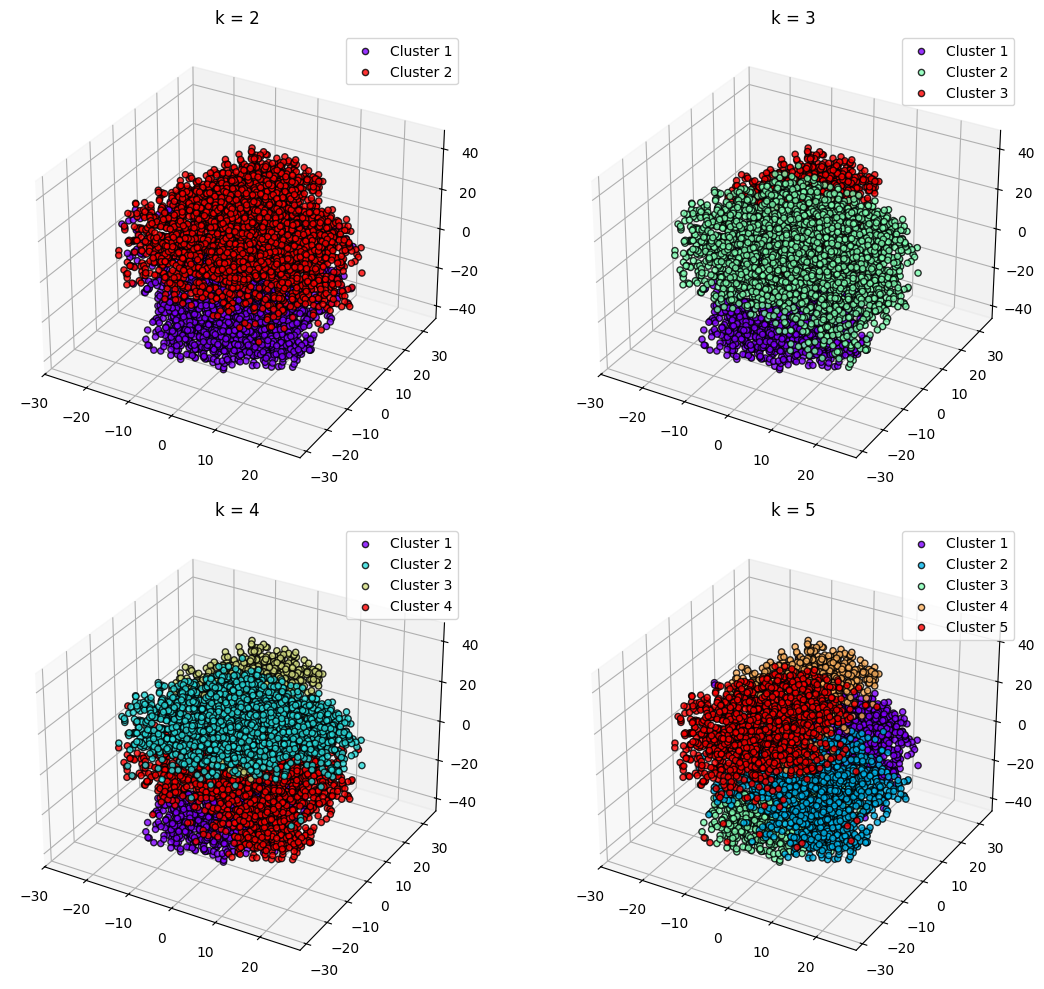

In [ ]:
plot_spectral_clusters(Y_3d_dict_custom, cluster_results_custom)
plot_spectral_clusters_plotly(Y_3d_dict_custom, cluster_results_custom)

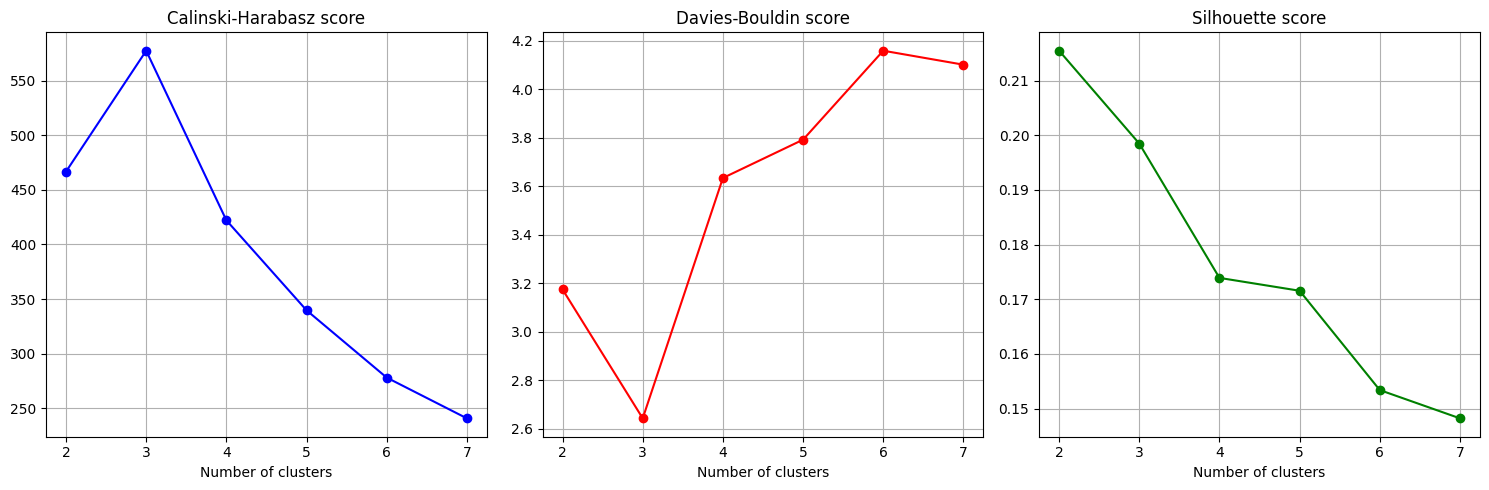

Optimal k according to Calinski-Harabasz: 3
Optimal k according to Davies-Bouldin: 3
Optimal k according to Silhouette: 2
Calinski-Harabasz scores: [466.63430081237675, 577.3169835834933, 422.080789937217, 339.69321209251046, 278.0682606701582, 240.76617990994777]
Davies-Bouldin scores: [3.17410229057737, 2.6426379257479673, 3.6337848632478167, 3.7917986588010466, 4.158676661771852, 4.101038639029608]
Silhouette scores: [0.21549316550280545, 0.1984982276568113, 0.17391302513830229, 0.17155762351936188, 0.1533801413394785, 0.14820641844785204]


In [ ]:

# 2. Perform clustering for different k values
from sklearn.cluster import SpectralClustering

cluster_results_custom_eval = {}
for k in [2, 3, 4, 5, 6, 7]:
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='precomputed',
        random_state=42
    )
    labels = spectral.fit_predict(similarity_matrix_custom)
    cluster_results_custom_eval[k] = labels

# 3. Evaluate clustering
ch_scores, db_scores, sil_scores = evaluate_clustering(X, cluster_results_custom_eval, L1rog_distances)

print("Calinski-Harabasz scores:", ch_scores)
print("Davies-Bouldin scores:", db_scores)
print("Silhouette scores:", sil_scores)

In [ ]:
import numpy as np

k_selected = 4  # Choose the appropriate k value

# Gower distance
# Ensure we get the correct cluster labels
cluster_labels_custom = np.array(cluster_results_custom[k_selected])

# Add to Pandas DataFrame (data)
data['Cluster'] = pd.Series(cluster_labels_custom, index=data.index)

# Add to NumPy array (X)
cluster_labels_custom = cluster_labels_custom.reshape(-1, 1)  # Ensure it's the right shape
X_with_clusters_custom = np.hstack((X, cluster_labels_custom))

# Save results
data.to_excel('data_with_clusters_custom.xlsx', index=False)
np.save('X_with_clusters_custom.npy', X_with_clusters_custom)  # Save NumPy array

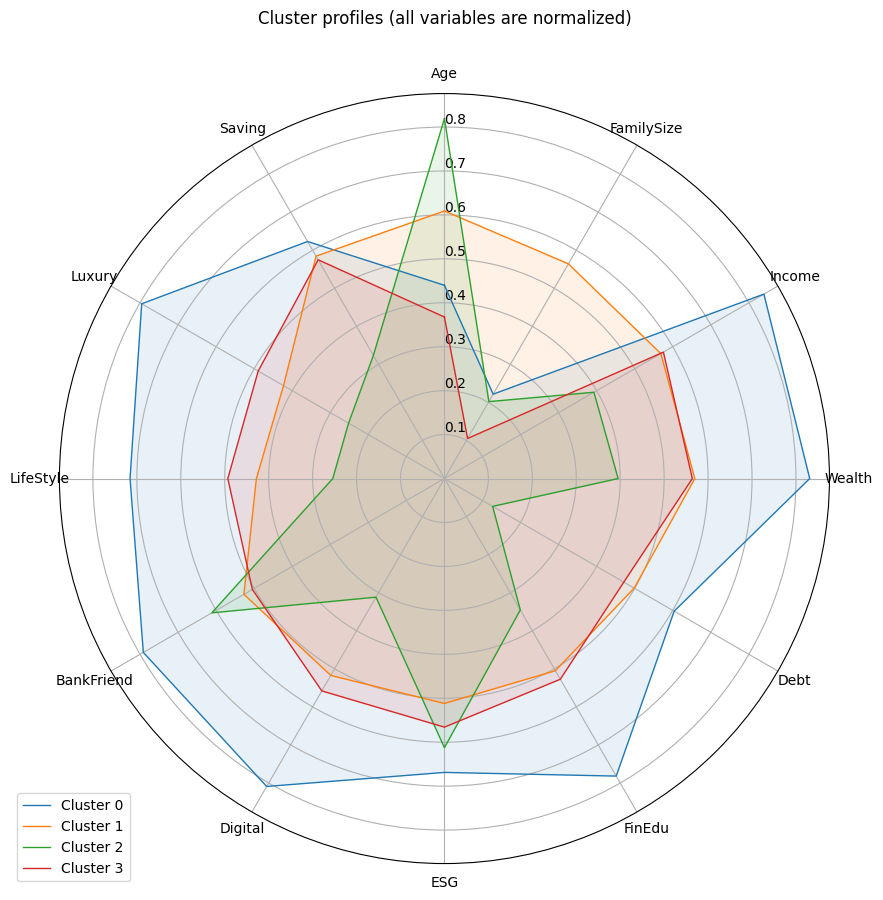

In [ ]:
data_clustered_custom = pd.read_excel('data_with_clusters_custom.xlsx')

plot_cluster_radar(data_clustered_custom)